In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense
import time

import matplotlib.pyplot as plt 

In [2]:
NUM_WORDS = 1024*16
MAXLEN = 256
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS,
                                                      skip_top=16, # не враховувати слів найчастіших за вживаністю
                                                      seed=int(time.time()) - 10-11-2023)

In [3]:
X_train = pad_sequences(X_train, maxlen=MAXLEN)
X_test = pad_sequences(X_test, maxlen=MAXLEN)

In [4]:
len(X_train)

25000

In [25]:
def plot_acc_loss_history(history, title=""):
    plt.figure(figsize=(13,3))

    ticks0 = range(0, len(history.history['accuracy']))
    ticks1 = range(1, len(history.history['accuracy'])+1)

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], marker='o', label='accuracy')
    plt.plot(history.history['val_accuracy'], marker='o', label='validate accuracy')
    plt.fill_between(range(len(history.history['accuracy'])), history.history['accuracy'], history.history['val_accuracy'], alpha=0.2)
    plt.grid()
    plt.xticks(ticks0, ticks1)
    plt.xlabel("Епоха")
    plt.ylabel("Точність")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], marker='o', label='loss')
    plt.plot(history.history['val_loss'], marker='o', label='validate loss')
    plt.fill_between(range(len(h.history['loss'])), history.history['loss'], history.history['val_loss'], alpha=0.2)
    plt.grid()
    plt.xticks(ticks0, ticks1)
    plt.xlabel("Епоха")
    plt.ylabel("Втрати")
    plt.legend()

    if len(title):
        plt.suptitle(title, fontsize=20)
    plt.show()

# **Simple RNN**

In [6]:
model_rnn = Sequential()
model_rnn.add(Embedding(NUM_WORDS, 32))
# model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(768, activation='relu'))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(256, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()

model_rnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00015, ema_momentum=1.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          524288    
                                                                 
 dense (Dense)               (None, None, 768)         25344     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               114816    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 697729 (2.66 MB)
Trainable params: 697729 

In [7]:
checkpointer = ModelCheckpoint(filepath="best_rnn.hdf5", verbose=1, save_best_only=True)

h = model_rnn.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=10,
                  batch_size=256,
                  callbacks=[checkpointer])

model_rnn.load_weights("best_rnn.hdf5")

loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=0)
print('[rnn]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5032
Epoch 1: val_loss improved from inf to 0.69157, saving model to best_rnn.hdf5


C:\Users\tedim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 168s 2s/step - loss: 0.6935 - accuracy: 0.5032 - val_loss: 0.6916 - val_accuracy: 0.5254
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5391
Epoch 2: val_loss improved from 0.69157 to 0.68746, saving model to best_rnn.hdf5
98/98 [==============================] - 157s 2s/step - loss: 0.6897 - accuracy: 0.5391 - val_loss: 0.6875 - val_accuracy: 0.5362
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.6605
Epoch 3: val_loss improved from 0.68746 to 0.52261, saving model to best_rnn.hdf5
98/98 [==============================] - 172s 2s/step - loss: 0.6167 - accuracy: 0.6605 - val_loss: 0.5226 - val_accuracy: 0.7408
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8218
Epoch 4: val_loss improved from 0.52261 to 0.38273, saving model to best_rnn.hdf5
98/98 [==============================] - 170s 2s/step - loss: 0.4034 - accuracy: 0

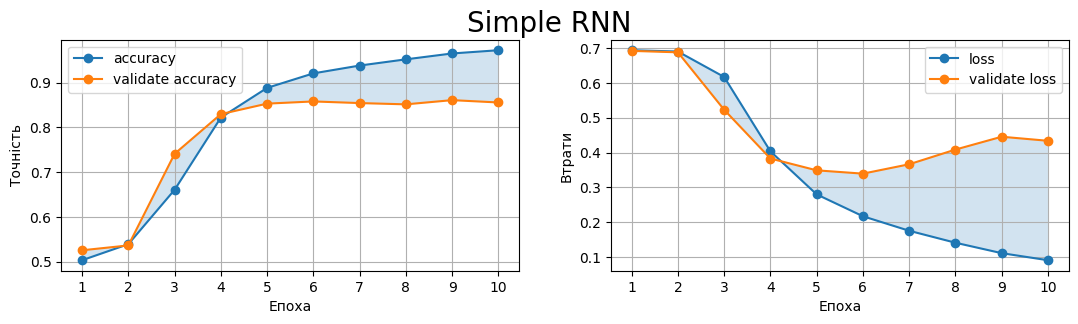

In [26]:
plot_acc_loss_history(h, "Simple RNN")

## Примітка

Початковій SimpleRNN моделі без додаткових шарів було характерно на перших кроках швидке навчання максимум до 84% з подальшим спадом менше 80% - відбувалося перенавчання. Шоб побороти це в дейтасеті ігнорувалися слова, що входять у 16 найуживаніших, та був доданий повнозв'язний шір між входом та SimpleRNN шаром та повнозв'язний шар після. Також шар Dropout допоміг зменшити ефект перенавчання, а підібрані гіперпараметри дозволили оптимізувати градієнтний спуск. Саме в такій комбінації досяглася максимальна точність при мінімумі помилок, але перенавчання все одно швидко настає.

**Фактично, SimpleRNN шар навчається не на вхідних даних, а на автовиявлених ознаках входу!** Це цікавий ефект, що потребує додаткового дослідження.

# **LSTM**

In [77]:
model_lstm = Sequential()
model_lstm.add(Embedding(NUM_WORDS, 32))
model_lstm.add(Dense(768, activation='relu'))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

model_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003, ema_momentum=1.9),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 32)          524288    
                                                                 
 dense_44 (Dense)            (None, None, 768)         25344     
                                                                 
 lstm_9 (LSTM)               (None, 128)               459264    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 512)               66048     
                                                                 
 dense_46 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1075457 (4.10 MB)
Trainable params: 107

In [78]:
checkpointer = ModelCheckpoint(filepath="best_lstm.hdf5", verbose=1, save_best_only=True)

h = model_lstm.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=15,
                   batch_size=256,
                   callbacks=[checkpointer])

model_lstm.load_weights("best_lstm.hdf5")

loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print('[lstm]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/15
98/98 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.6014
Epoch 1: val_loss improved from inf to 0.54983, saving model to best_lstm.hdf5
98/98 [==============================] - 617s 6s/step - loss: 0.6561 - accuracy: 0.6014 - val_loss: 0.5498 - val_accuracy: 0.7394
Epoch 2/15
98/98 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.8410
Epoch 2: val_loss improved from 0.54983 to 0.33612, saving model to best_lstm.hdf5
98/98 [==============================] - 794s 8s/step - loss: 0.3722 - accuracy: 0.8410 - val_loss: 0.3361 - val_accuracy: 0.8564
Epoch 3/15
98/98 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9179
Epoch 3: val_loss improved from 0.33612 to 0.30689, saving model to best_lstm.hdf5
98/98 [==============================] - 738s 8s/step - loss: 0.2170 - accuracy: 0.9179 - val_loss: 0.3069 - val_accuracy: 0.8725
Epoch 4/15
98/98 [==============================] - ETA: 0s - loss: 0.1647 - accura

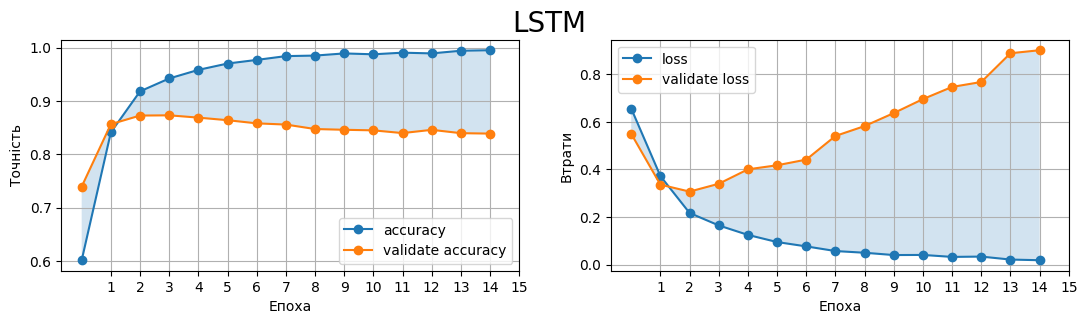

In [79]:
plot_acc_loss_history(h, "LSTM")

# **Bidirectional**

In [71]:
model_bdlstm = Sequential()
model_bdlstm.add(Embedding(NUM_WORDS,54))
model_bdlstm.add(Bidirectional(LSTM(64)))
model_bdlstm.add(Dense(1, activation='sigmoid'))
model_bdlstm.summary()

# model_bdlstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bdlstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003, ema_momentum=1.9),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 54)          884736    
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               60928     
 onal)                                                           
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 945793 (3.61 MB)
Trainable params: 945793 (3.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
checkpointer = ModelCheckpoint(filepath="best_bdlstm.hdf5", verbose=1, save_best_only=True)

h = model_bdlstm.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=15,
                   batch_size=256,
                   callbacks=[checkpointer])

model_bdlstm.load_weights("best_bdlstm.hdf5")

loss, accuracy = model_bdlstm.evaluate(X_test, y_test, verbose=1)
print('[bdlstm]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/15
98/98 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.6041
Epoch 1: val_loss improved from inf to 0.59654, saving model to best_bdlstm.hdf5
98/98 [==============================] - 583s 6s/step - loss: 0.6638 - accuracy: 0.6041 - val_loss: 0.5965 - val_accuracy: 0.7136
Epoch 2/15
98/98 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8286
Epoch 2: val_loss improved from 0.59654 to 0.36846, saving model to best_bdlstm.hdf5
98/98 [==============================] - 623s 6s/step - loss: 0.4418 - accuracy: 0.8286 - val_loss: 0.3685 - val_accuracy: 0.8546
Epoch 3/15
98/98 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8971
Epoch 3: val_loss improved from 0.36846 to 0.31994, saving model to best_bdlstm.hdf5
98/98 [==============================] - 618s 6s/step - loss: 0.2842 - accuracy: 0.8971 - val_loss: 0.3199 - val_accuracy: 0.8721
Epoch 4/15
98/98 [==============================] - ETA: 0s - loss: 0.2175 - 

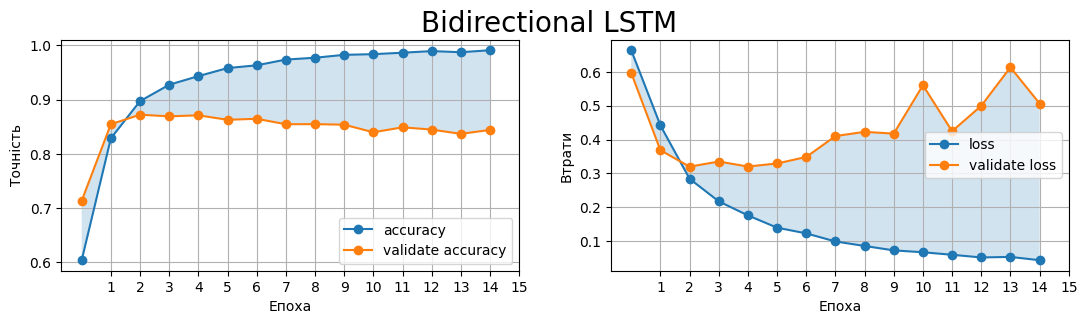

In [73]:
plot_acc_loss_history(h, "Bidirectional LSTM")

In [81]:
model_bdrnn = Sequential()
model_bdrnn.add(Embedding(NUM_WORDS, 32))
model_bdrnn.add(Bidirectional(SimpleRNN(64)))
model_bdrnn.add(Dropout(0.75))
# model_bdrnn.add(Dense(256, activation='relu'))
model_bdrnn.add(Dense(1, activation='sigmoid'))
model_bdrnn.summary()

model_bdrnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00015, ema_momentum=1.9),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 32)          524288    
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               12416     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 1)                 129       
                                                                 
Total params: 536833 (2.05 MB)
Trainable params: 536833 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model_bdrnn = Sequential()
model_bdrnn.add(Embedding(NUM_WORDS, 32))
model_bdrnn.add(Dense(768, activation='relu'))
model_bdrnn.add(Bidirectional(SimpleRNN(64)))
model_bdrnn.add(Dropout(0.5))
model_bdrnn.add(Dense(256, activation='relu'))
model_bdrnn.add(Dense(1, activation='sigmoid'))
model_bdrnn.summary()

model_bdrnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00015, ema_momentum=1.9),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          35552     
                                                                 
 dense_15 (Dense)            (None, None, 768)         25344     
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               106624    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                     

In [82]:
checkpointer = ModelCheckpoint(filepath="best_bdrnn.hdf5", verbose=1, save_best_only=True)

h = model_bdrnn.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=15,
                    batch_size=256,
                    callbacks=[checkpointer])

model_bdrnn.load_weights("best_bdrnn.hdf5")

loss, accuracy = model_bdrnn.evaluate(X_test, y_test, verbose=1)
print('[bdrnn]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/15
98/98 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.5117
Epoch 1: val_loss improved from inf to 0.68565, saving model to best_bdrnn.hdf5
98/98 [==============================] - 141s 1s/step - loss: 0.6992 - accuracy: 0.5117 - val_loss: 0.6857 - val_accuracy: 0.5502
Epoch 2/15
98/98 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5695
Epoch 2: val_loss improved from 0.68565 to 0.67689, saving model to best_bdrnn.hdf5
98/98 [==============================] - 142s 1s/step - loss: 0.6777 - accuracy: 0.5695 - val_loss: 0.6769 - val_accuracy: 0.5862
Epoch 3/15
98/98 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.6616
Epoch 3: val_loss improved from 0.67689 to 0.61592, saving model to best_bdrnn.hdf5
98/98 [==============================] - 137s 1s/step - loss: 0.6348 - accuracy: 0.6616 - val_loss: 0.6159 - val_accuracy: 0.6864
Epoch 4/15
98/98 [==============================] - ETA: 0s - loss: 0.5382 - acc

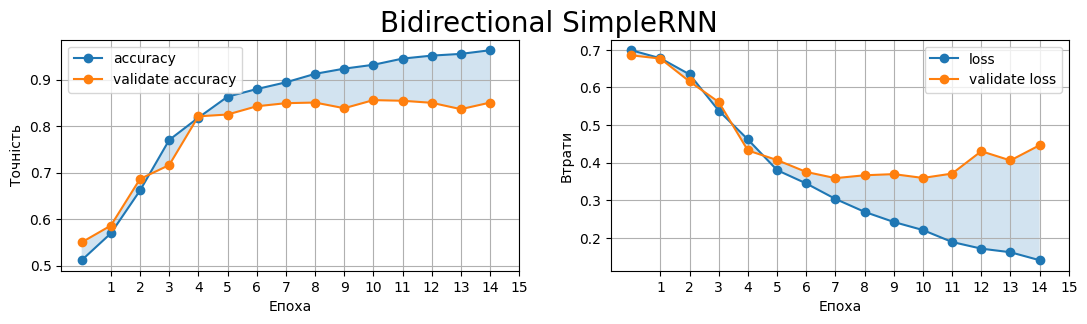

In [83]:
plot_acc_loss_history(h, "Bidirectional SimpleRNN")

return_sequences=True

## Примітка

Складається враження, що двунаправлені нейромережі не підходять для задачі, схожій на сентимент-аналіз, оскільки "читання" речень у зворотньому порядку не дають нової інформації для передбачення.

# **Глибокі (deep) нейромережі**

In [111]:
model_dprnn = Sequential()
model_dprnn.add(Embedding(NUM_WORDS, 32))
model_dprnn.add(SimpleRNN(128, return_sequences=True))
# model_dprnn.add(Dropout(0.5))
model_dprnn.add(SimpleRNN(64))
model_dprnn.add(Dense(1, activation='sigmoid'))
model_dprnn.summary()

model_dprnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, None, 32)          524288    
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, None, 128)         20608     
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dense_58 (Dense)            (None, 1)                 65        
                                                                 
Total params: 557313 (2.13 MB)
Trainable params: 557313 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
checkpointer = ModelCheckpoint(filepath="best_dprnn.hdf5", verbose=1, save_best_only=True)

h = model_dprnn.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64,
                    callbacks=[checkpointer])

model_dprnn.load_weights("best_dprnn.hdf5")

loss, accuracy = model_dprnn.evaluate(X_test, y_test, verbose=1)
print('[dprnn]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.5538
Epoch 1: val_loss improved from inf to 0.62019, saving model to best_dprnn.hdf5
391/391 [==============================] - 262s 664ms/step - loss: 0.6736 - accuracy: 0.5538 - val_loss: 0.6202 - val_accuracy: 0.6372
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5763 - accuracy: 0.6961
Epoch 2: val_loss improved from 0.62019 to 0.53712, saving model to best_dprnn.hdf5
391/391 [==============================] - 257s 657ms/step - loss: 0.5763 - accuracy: 0.6961 - val_loss: 0.5371 - val_accuracy: 0.7272
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.7992
Epoch 3: val_loss improved from 0.53712 to 0.46250, saving model to best_dprnn.hdf5
391/391 [==============================] - 249s 636ms/step - loss: 0.4462 - accuracy: 0.7992 - val_loss: 0.4625 - val_accuracy: 0.8076
Epoch 4/10
391/391 [==============================] - ETA: 

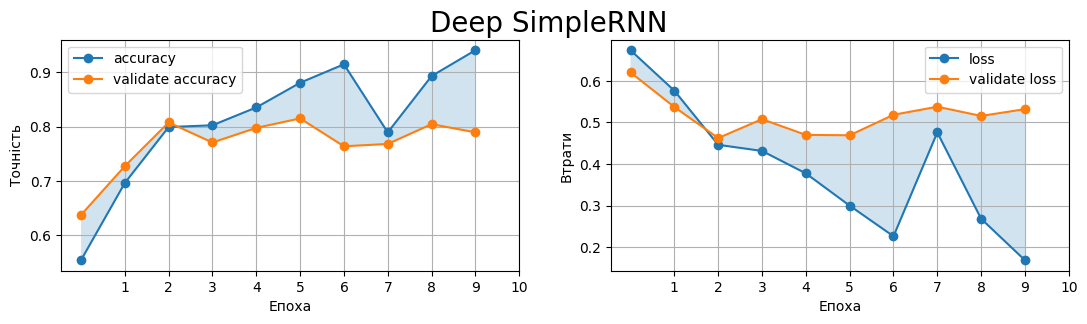

In [113]:
plot_acc_loss_history(h, "Deep SimpleRNN")

In [95]:
model_dpgru = Sequential()
model_dpgru.add(Embedding(NUM_WORDS, 32))
model_dpgru.add(GRU(128, return_sequences=True))
model_dpgru.add(Dropout(0.9))
model_dpgru.add(GRU(64))
model_dpgru.add(Dense(1, activation='sigmoid'))
model_dpgru.summary()

model_dpgru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 32)          524288    
                                                                 
 gru_4 (GRU)                 (None, None, 128)         62208     
                                                                 
 dropout_23 (Dropout)        (None, None, 128)         0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 623809 (2.38 MB)
Trainable params: 623809 (2.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
checkpointer = ModelCheckpoint(filepath="best_dpgru.hdf5", verbose=1, save_best_only=True)

h = model_dpgru.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64,
                    callbacks=[checkpointer])

model_dpgru.load_weights("best_dpgru.hdf5")

loss, accuracy = model_dpgru.evaluate(X_test, y_test, verbose=1)
print('[dpgru]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7258
Epoch 1: val_loss improved from inf to 0.39392, saving model to best_dpgru.hdf5
391/391 [==============================] - 782s 2s/step - loss: 0.5217 - accuracy: 0.7258 - val_loss: 0.3939 - val_accuracy: 0.8354
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8880
Epoch 2: val_loss improved from 0.39392 to 0.35128, saving model to best_dpgru.hdf5
391/391 [==============================] - 794s 2s/step - loss: 0.2811 - accuracy: 0.8880 - val_loss: 0.3513 - val_accuracy: 0.8574
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9319
Epoch 3: val_loss improved from 0.35128 to 0.34589, saving model to best_dpgru.hdf5
391/391 [==============================] - 808s 2s/step - loss: 0.1849 - accuracy: 0.9319 - val_loss: 0.3459 - val_accuracy: 0.8612
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss

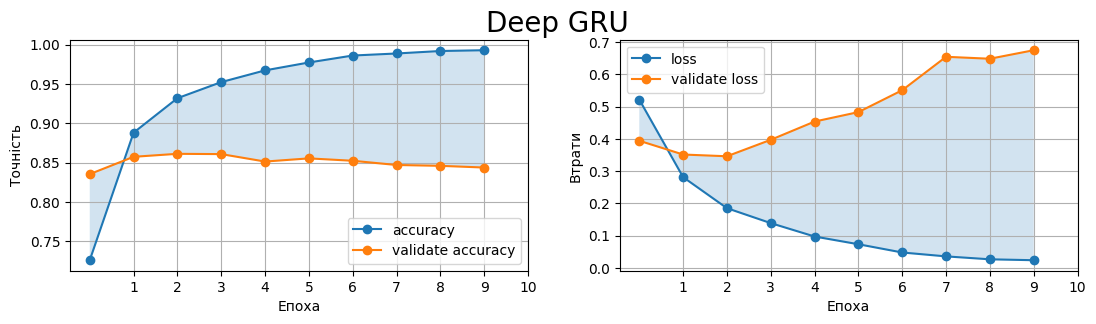

In [97]:
plot_acc_loss_history(h, "Deep GRU")

In [86]:
model_dplstm = Sequential()
model_dplstm.add(Embedding(NUM_WORDS, 32))
model_dplstm.add(LSTM(128, return_sequences=True))
model_dplstm.add(Dropout(0.5))
model_dplstm.add(LSTM(64))
model_dplstm.add(Dense(1, activation='sigmoid'))
model_dplstm.summary()

model_dplstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, None, 32)          524288    
                                                                 
 lstm_14 (LSTM)              (None, None, 128)         82432     
                                                                 
 dropout_20 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                49408     
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 656193 (2.50 MB)
Trainable params: 656193 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
checkpointer = ModelCheckpoint(filepath="best_dplstm.hdf5", verbose=1, save_best_only=True)

h = model_dplstm.fit(X_train, y_train,
                     validation_data=(X_test, y_test),
                     epochs=10,
                     batch_size=64,
                     callbacks=[checkpointer])

model_dplstm.load_weights("best_dplstm.hdf5")

loss, accuracy = model_dplstm.evaluate(X_test, y_test, verbose=1)
print('[dplstm]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.7847
Epoch 1: val_loss improved from inf to 0.36771, saving model to best_dplstm.hdf5
391/391 [==============================] - 1085s 3s/step - loss: 0.4443 - accuracy: 0.7847 - val_loss: 0.3677 - val_accuracy: 0.8450
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9048
Epoch 2: val_loss improved from 0.36771 to 0.34629, saving model to best_dplstm.hdf5
391/391 [==============================] - 1178s 3s/step - loss: 0.2475 - accuracy: 0.9048 - val_loss: 0.3463 - val_accuracy: 0.8658
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9384
Epoch 3: val_loss did not improve from 0.34629
391/391 [==============================] - 1173s 3s/step - loss: 0.1714 - accuracy: 0.9384 - val_loss: 0.3783 - val_accuracy: 0.8652
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9561
Epoc

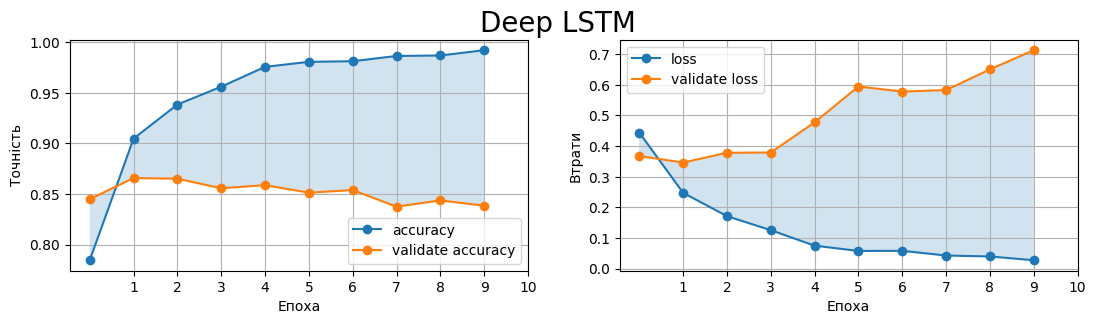

In [89]:
plot_acc_loss_history(h, "Deep LSTM")

In [116]:
model_dbrnn = Sequential()
model_dbrnn.add(Embedding(NUM_WORDS, 32))
model_dbrnn.add(SimpleRNN(128, return_sequences=True))
model_dbrnn.add(Bidirectional(SimpleRNN(64)))
model_dbrnn.add(Dropout(0.5))
model_dbrnn.add(Dense(256, activation='relu'))
model_dbrnn.add(Dense(1, activation='sigmoid'))
model_dbrnn.summary()

model_dbrnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00015, ema_momentum=1.9),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, None, 32)          524288    
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, None, 128)         20608     
                                                                 
 bidirectional_9 (Bidirecti  (None, 128)               24704     
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 256)               33024     
                                                                 
 dense_62 (Dense)            (None, 1)                 257       
                                                     

In [118]:
checkpointer = ModelCheckpoint(filepath="best_dbrnn.hdf5", verbose=1, save_best_only=True)

h = model_dbrnn.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64,
                    callbacks=[checkpointer])

model_dbrnn.load_weights("best_dbrnn.hdf5")

loss, accuracy = model_dbrnn.evaluate(X_test, y_test, verbose=1)
print('[dbrnn]\t Test Accuracy: {:.2f}%'.format(accuracy * 100))

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5064
Epoch 1: val_loss improved from inf to 0.69437, saving model to best_dbrnn.hdf5
391/391 [==============================] - 396s 987ms/step - loss: 0.6984 - accuracy: 0.5064 - val_loss: 0.6944 - val_accuracy: 0.5080
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5326
Epoch 2: val_loss improved from 0.69437 to 0.68195, saving model to best_dbrnn.hdf5
391/391 [==============================] - 383s 981ms/step - loss: 0.6892 - accuracy: 0.5326 - val_loss: 0.6820 - val_accuracy: 0.5506
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.6988
Epoch 3: val_loss improved from 0.68195 to 0.39450, saving model to best_dbrnn.hdf5
391/391 [==============================] - 382s 978ms/step - loss: 0.5698 - accuracy: 0.6988 - val_loss: 0.3945 - val_accuracy: 0.8310
Epoch 4/10
391/391 [==============================] - ETA: 

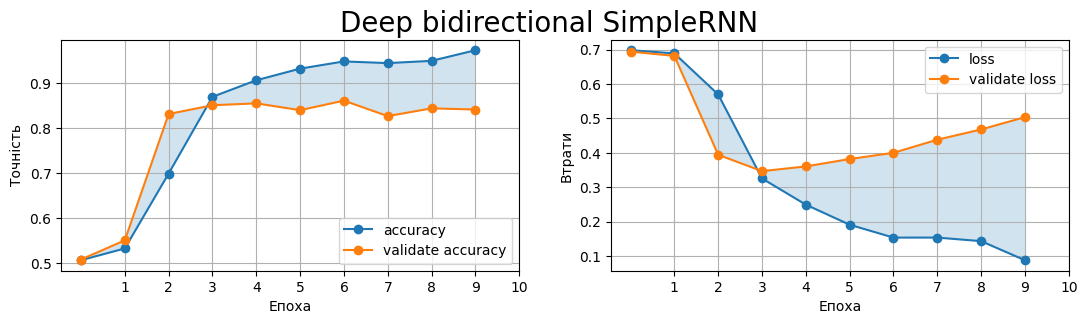

In [119]:
plot_acc_loss_history(h, "Deep bidirectional SimpleRNN")

# **Висновок:**

Відсортовані результати:
1. [lstm]	 Test Accuracy: 87.25%
2. [bdlstm]  Test Accuracy: 87.21%
3. [dplstm]  Test Accuracy: 86.58%
4. [dpgru]	 Test Accuracy: 86.12%
5. [rnn]	 Test Accuracy: 85.77%
6. [dbrnn]	 Test Accuracy: 85.04%
7. [bdrnn]	 Test Accuracy: 84.93%
8. [dprnn]	 Test Accuracy: 80.76%

Відсортовані результати показують, що найбільше значення має архітектура мережі, а саме LSTM. Для LSTM орієнтована довго пам'ятати важливе і швидко забувати другорядне.

Даній задачі характерно швидке навчання, після чого йде перенавчання. Додаткові повнозв'язні шари, шари Dropout та корегування гіперпараметрів не сильно допомогають в боротьбі з цим ефектом. Тільки зменшення MAX_WORDS реально допомогає зменшити ефект перенавчання при певному зниженні точності. В принципі - швидке навчання - це не настільки й погано, оскільки економить час.

Двосторонні нейромережі очікувано показали, що вони позитивно не впливають на результат, оскільки більше орієнтовані на врахування апостеріорного оточення для передбачень, а не для кінцевого висновку на всьому вхідному тексті.